In [34]:
using Flux
using Flux.Data: DataLoader
using Flux.Optimise: Optimiser, WeightDecay
using Flux: onehotbatch, onecold, logitcrossentropy
using Statistics, Random
using Parameters: @with_kw
using Logging: with_logger, global_logger
import ProgressMeter
import MLDatasets
import DrWatson: savename, struct2dict
import BSON
using CUDAapi
using CuArrays
using Plots
import GR
using ImageCore

# Define Model

## VGG16

In [19]:
function Model(; imgsize=(32,32,3), nclasses=10) 
#     out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    
    return Chain(
            x -> reshape(x, imgsize..., :),
        Conv((3, 3), imgsize[end]=>64, relu,pad = (1,1),stride=(1,1)),
            BatchNorm(64),
            Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(64),
            MaxPool((2,2)),
            Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(128),
            Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(128),
            MaxPool((2,2)),
            Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            MaxPool((2,2)),
            Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            MaxPool((2,2)),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            MaxPool((2,2)),
            flatten,
            Dense(512, 4096, relu),
            Dropout(0.5),
            Dense(4096, 4096, relu),
            Dropout(0.5),
            Dense(4096, nclasses)) |> gpu
#             MaxPool((2, 2)),
#             Conv((5, 5), 6=>16, relu),
#             MaxPool((2, 2)),
#             x -> reshape(x, :, size(x, 4)),
#             Dense(prod(out_conv_size), 120, relu), 
#             Dense(120, 84, relu), 
#             Dense(84, nclasses)
#           )
end

Model (generic function with 1 method)

# Show Batch (change dataset)

In [20]:
function showBatch(noImages)
    p = plot(axis = nothing,layout = noImages);

    for x in 1:noImages
                plot!(p[x],MLDatasets.CIFAR10.convert2image(MLDatasets.CIFAR10.traintensor(x)))
    
    end
    display(p)
end
    

showBatch (generic function with 1 method)

# Get Data

In [21]:
function get_data(args)
    xtrain, ytrain = MLDatasets.CIFAR10.traindata(Float32)
    xtest, ytest = MLDatasets.CIFAR10.testdata(Float32)
    showBatch(10)
    
    xtrain = reshape(xtrain, args.imsize, args.imsize, args.channels, :)
    xtest = reshape(xtest, args.imsize, args.imsize, args.channels, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader(xtrain, ytrain, batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader(xtest, ytest,  batchsize=args.batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 1 method)

# Loss Func

In [22]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

loss (generic function with 1 method)

In [23]:
function eval_loss_accuracy(loader, model, device)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in loader
        x, y = x |> device, y |> device
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(onecold(ŷ |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

eval_loss_accuracy (generic function with 1 method)

# Helper (Number of params and round function

In [24]:
num_params(model) = sum(length, Flux.params(model)) 
round4(x) = round(x, digits=4)

round4 (generic function with 1 method)

# Define Parameters

In [29]:
@with_kw mutable struct Args
    η = 3e-4             # lr
    λ = 0                # weightDecay
    batchsize = 128      
    epochs = 50          
    seed = 0             
    cuda = true          
    infotime = 10
    logtime = 5
    checktime = 20          
    savepath = nothing
    imsize = 32
    channels= 3
end

Args

# Train

In [35]:
function train(; kws...)
    args = Args(; kws...)
    args.seed > 0 && Random.seed!(args.seed)
    use_cuda = args.cuda && CUDAapi.has_cuda_gpu()
    if use_cuda
        device = gpu
        CuArrays.allowscalar(false)
        @info "Training on GPU"
    end

    train_loader, test_loader = get_data(args)
    @info "$(train_loader.nobs) train and $(test_loader.nobs) valid examples"

    model = Model() |> device
    @info "Model Info: $(num_params(model)) trainable params"    
    
    ps = Flux.params(model)  
    gr()

    opt = ADAMW(args.η) 
    epoch_loss_train = zeros(0)
    epoch_loss_test = zeros(0)
    if args.λ > 0 
        opt = Optimiser(opt, WeightDecay(args.λ))
    end
    
    if args.savepath == nothing
        experiment_folder = savename("model", args, scientific=4,
                    accesses=[:batchsize, :η, :seed, :λ]) 
        args.savepath = joinpath("runs", experiment_folder)
    end
  
    function report(epoch)
        train = eval_loss_accuracy(train_loader, model, device)
        test = eval_loss_accuracy(test_loader, model, device)        
        println("Epoch: $epoch   Train: $(train)   Test: $(test)")

        pl = plot(epoch_loss_train,label = "Train Loss")
        display(plot!(pl, epoch_loss_test,label = "Test Loss"))
        
    end
    
    @info "Starting Training"
#     report(0)
    for epoch in 1:args.epochs
        @info epoch
        p = ProgressMeter.Progress(args.epochs)

        for (x, y) in train_loader
            x, y = x |> device, y |> device
            gs = Flux.gradient(ps) do
                ŷ = model(x)
                loss(ŷ, y)
            end
            Flux.Optimise.update!(opt, ps, gs)
            
        end
        if epoch%args.logtime==0
            train = eval_loss_accuracy(train_loader, model, device)
            test = eval_loss_accuracy(test_loader, model, device)        
            push!(epoch_loss_train,convert(AbstractFloat, train.loss))

            push!(epoch_loss_test,convert(AbstractFloat, test.loss))
        end
        epoch % args.infotime == 0 && report(epoch)
        ProgressMeter.next!(p)
        if args.checktime > 0 && epoch % args.checktime == 0
            !ispath(args.savepath) && mkpath(args.savepath)
            modelpath = joinpath(args.savepath, "model.bson") 
            let model=cpu(model), args=struct2dict(args)
                BSON.@save modelpath model epoch args
            end
            @info "Model saved in \"$(modelpath)\""
        end
        
    end
end

train (generic function with 1 method)

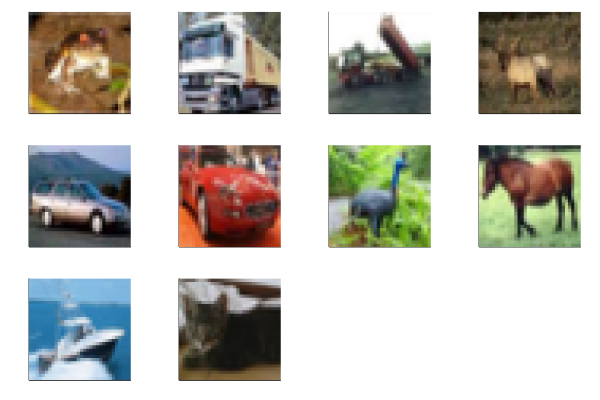

┌ Info: Training on GPU
└ @ Main In[35]:8
┌ Info: 50000 train and 10000 valid examples
└ @ Main In[35]:12
┌ Info: Model Info: 33646666 trainable params
└ @ Main In[35]:15
┌ Info: Starting Training
└ @ Main In[35]:43
┌ Info: 1
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:02:51┌ Info: 2
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:02:51┌ Info: 3
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:02:51┌ Info: 4
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:03:00┌ Info: 5
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:18:03┌ Info: 6
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:02:51┌ Info: 7
└ @ Main In[35]:46
Progress:   2%|▉                                        |  ETA: 1:02:58┌ Info: 8
└ @ Main In[35]:46
Progress:   2%|▉                                       

InterruptException: InterruptException:

In [36]:
train()